In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

In [2]:
cid ='fd0f694eb3df41f1ae48bc7d0d8d5a3a'
secret = 'f06d7ba6bc094ea5944622f77c77462d'
username = ''

scope = 'user-library-read playlist-modify-public playlist-read-private'

redirect_uri='http://localhost:8888'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [3]:
import pandas as pd

playlistID = '37i9dQZF1Etr76TQzqcYgZ'
playlist = sp.user_playlist(username, playlistID)

tracks = playlist['tracks']
songs = tracks['items']

track_ids = []
track_names = []

for i in range(0, len(songs)):
    if songs[i]['track']['id'] != None:
        track_ids.append(songs[i]['track']['id'])
        track_names.append(songs[i]['track']['name'])
        
#compiles audio features of songs in playlist
features = []
for i in range(0, len(track_ids)):
    audio_features = sp.audio_features(track_ids[i])
    for track in audio_features:
        features.append(track)
        
playlist_df= pd.DataFrame(features, index = track_names)

#only keeps relevant audio features
playlist_df = playlist_df[["id", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]
playlist_df.head()

#generate relevancy on 1-10 scale for each song in playlist 
#assume beginning of playlist t be more relevant (divide into fifths)
def populate_ratings(array=[]):
    i= 0
    first = len(songs)//5
    second = len(songs)//5+first
    third = len(songs)//5+second
    fourth = len(songs)//5+third

    while i < len(songs):
        if i <= first:
            array.append(10)
            i+=1
        elif i <= second:
            array.append(8)
            i+=1
        elif i <= third:
            array.append(8)
            i+=1
        elif i <= fourth:
            array.append(8)
            i+=1
        else:
            array.append(6)
            i+=1
    return array

playlist_df['ratings'] = populate_ratings()
print(playlist_df['ratings'])   


retrying ...1secs
retrying ...2secs
retrying ...1secs
Quit You             10
Honolulu             10
Empty                10
Did It Again         10
W.I.N.               10
                     ..
Con Calma - Remix     6
hot girl bummer       6
Scream                6
Sunburn               6
Envy Me               6
Name: ratings, Length: 100, dtype: int64


In [4]:
import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

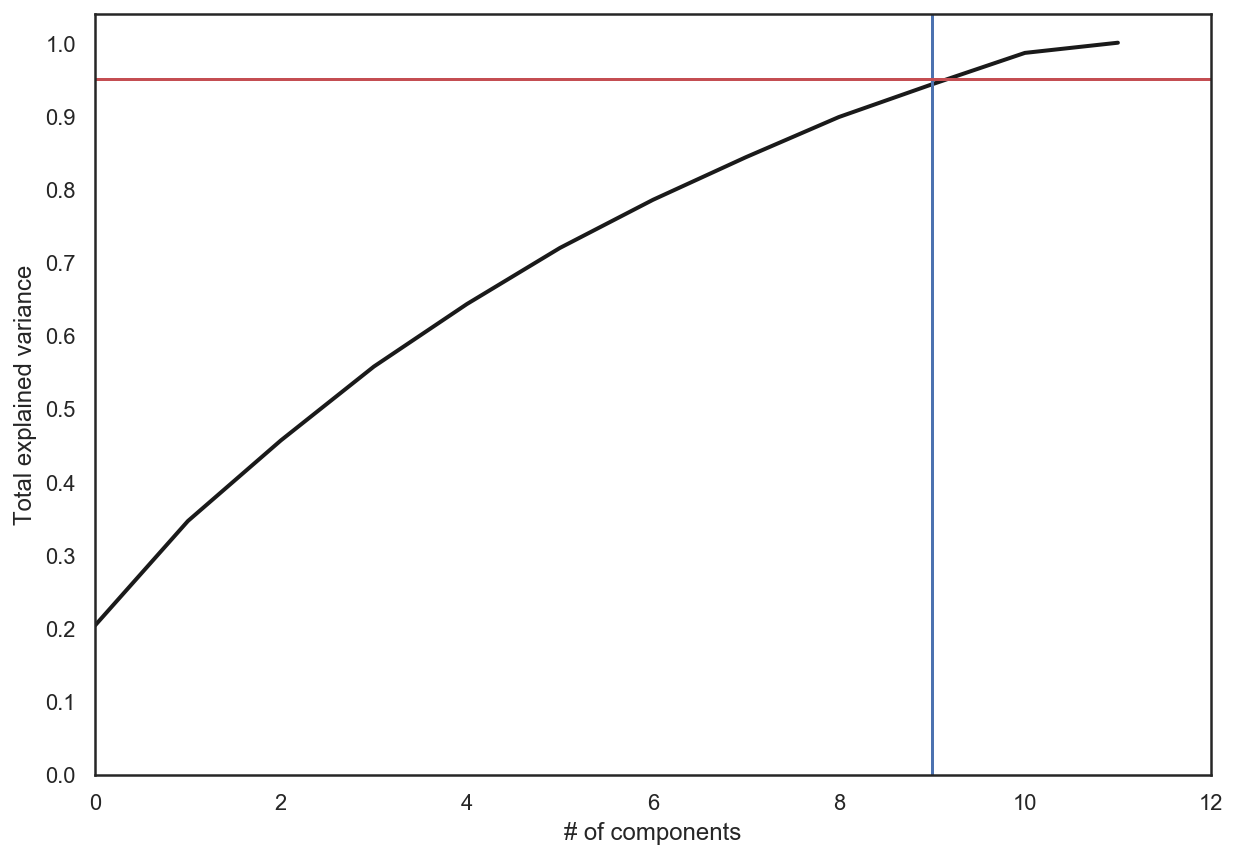

In [5]:
#apply pca to scale train set

x_train = playlist_df.drop(['id','ratings'], axis = 1)
y_train = playlist_df['ratings']

x_scale = StandardScaler().fit_transform(x_train) 

pca = decomposition.PCA().fit(x_scale)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_),color = 'k', lw = 2)
plt.xlabel('# of components')
plt.ylabel('Total explained variance')
plt.xlim(0,12)
plt.yticks(np.arange(0,1.1,0.1))
plt.axvline(9,c ='b')
plt.axhline(0.95, c = 'r')
plt.show()


In [6]:
#fit data using optimal pca
opt_pca = decomposition.PCA(n_components = 9)
x_pca = opt_pca.fit_transform(x_scale)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 6), max_features=10000)
x_names_sparse = v.fit_transform(track_names)
x_names_sparse.shape

from scipy.sparse import csr_matrix, hstack

x_train_last = csr_matrix(hstack([x_pca, x_names_sparse]))

In [8]:
#initializes stratified 5-fold for cross-validation
from sklearn.model_selection import StratifiedKFold, GridSearchCV
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)


In [9]:
#train KNeighbors Classifier

from sklearn.neighbors import KNeighborsClassifier
kn_parameters = {'n_neighbors': range(1,10)}
kn = KNeighborsClassifier(n_jobs = -1)
kn_grid = GridSearchCV(kn, kn_parameters, cv = skf, n_jobs = -1, verbose = True)
kn_grid.fit(x_train_last, y_train)
kn_grid.best_params_, kn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished
/Users/sahilmorchi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'n_neighbors': 8}, 0.6)

In [10]:
#train Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier
rf_parameters = {'max_features': [4,7,8,10], 'min_samples_leaf': [1,3,5,8], 'max_depth': [3,5,8]}
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1, oob_score = True)
rf_grid = GridSearchCV(rf, rf_parameters, n_jobs = -1, cv = skf, verbose = 1)
rf_grid.fit(x_train_last, y_train)
rf_grid.best_estimator_, rf_grid.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.3s finished
/Users/sahilmorchi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=3, max_features=4, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                        warm_start=False), 0.6)

In [11]:
#train Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}

tree_grid = GridSearchCV(tree, tree_params, cv=skf, n_jobs=-1, verbose=True)

tree_grid.fit(x_train_last, y_train)
tree_grid.best_estimator_, tree_grid.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished
/Users/sahilmorchi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=13, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'), 0.61)

In [ ]:
rec_tracks = []
for i in playlist_df['id'].values.tolist():
    rec_tracks += sp.recommendations(seed_tracks=[i], limit=int(len(playlist_df)/2))['tracks']

rec_track_ids = []
rec_track_names = []
for i in rec_tracks:
    rec_track_ids.append(i['id'])
    rec_track_names.append(i['name'])

rec_features = []
for i in range(0,len(rec_track_ids)):
    rec_audio_features = sp.audio_features(rec_track_ids[i])
    for track in rec_audio_features:
        rec_features.append(track)
        
rec_playlist_df = pd.DataFrame(rec_features, index = rec_track_ids)
rec_playlist_df.head()

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
